In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.layers import Input, Embedding, Activation, Flatten, Dense
from keras.layers import Conv1D, MaxPooling1D, Dropout,LSTM
from keras.models import Model


2022-12-02 23:09:48.452625: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-02 23:09:48.802966: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-02 23:09:48.803027: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-02 23:09:48.905918: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-02 23:09:50.131931: W tensorflow/stream_executor/platform/de

In [2]:
############Loading the data###############


train_data_source = 'train.csv'
test_data_source = 'test.csv'

train_df = pd.read_csv(train_data_source, header=None)
test_df = pd.read_csv(test_data_source, header=None)


####### Data Preprocessing part #########

# Each of the row in dataset is (class,title,text)
# combining title and text into second column and dropping that column



train_df[1]=train_df[1]+train_df[2]
test_df[1]=test_df[1]+test_df[2]

train_df=train_df.drop([2],axis=1)
test_df=test_df.drop([2],axis=1)


# convert text_string to lower case 
train_texts = [s.lower() for s in train_df[1].values] 
test_texts = [s.lower() for s in test_df[1].values] 


In [3]:

# Tokenizer
# Parameteres used:
# num_words=None, since we want to keep all words (here eword referes to character) and not just most frequenet some 'x' words
# oov_token='UNK', as we consider oov words also
tk = Tokenizer(num_words=None, char_level=True, oov_token='UNK',lower=True)

# It will understand the train string data that is provided and has direct functions to give results
tk.fit_on_texts(train_texts)


# Vocabulary of size 69 (excluding 'UNK' token)used 
alphabet="abcdefghijklmnopqrstuvwxyz0123456789 ,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}" 

#creating word2index dictionary (1-based indexing)
char_dict = {}
for index in range(0,len(alphabet)):
    char_dict[alphabet[index]] = index + 1
    
# Use char_dict to replace the tk.word_index
tk.word_index = char_dict.copy() 
# Add 'UNK' to the vocabulary 
tk.word_index[tk.oov_token] = len(alphabet) + 1


# Convert the concatenated string to vector of numbers corresponding to the number for each token in vocabulary
train_sequences = tk.texts_to_sequences(train_texts)
test_texts = tk.texts_to_sequences(test_texts)



In [4]:
# Padding with zeros till maximum length of 1014 and terminating if number of characters have exceeded 1014
train_data=np.array(np.zeros((len(train_sequences),1014)))
test_data=np.array(np.zeros((len(test_texts),1014)))

pos=0
for seq in train_sequences:
    x=pad_sequences([seq], maxlen=1014, padding='post')
    x=np.array(x)
    train_data[pos]=x
    pos+=1
pos=0
for seq in test_texts:
    x=pad_sequences([seq], maxlen=1014, padding='post')
    x=np.array(x)
    test_data[pos]=x
    pos+=1
# train_data = pad_sequences(train_sequences, maxlen=1014, padding='post')
# test_data = pad_sequences(test_texts, maxlen=1014, padding='post')

# Convert to numpy array
train_data = np.array(train_data, dtype='float32')
test_data = np.array(test_data, dtype='float32')

# Now we are having each row of the train data as 1014 length (format of numpy array)

In [5]:
print(train_texts[0])
print(train_sequences[0])

print(train_data[0][:30])
print(train_data[0])

wall st. bears claw back into the black (reuters)reuters - short-sellers, wall street's dwindling\band of ultra-cynics, are seeing green again.
[23, 1, 12, 12, 37, 19, 20, 40, 37, 2, 5, 1, 18, 19, 37, 3, 12, 1, 23, 37, 2, 1, 3, 11, 37, 9, 14, 20, 15, 37, 20, 8, 5, 37, 2, 12, 1, 3, 11, 37, 64, 18, 5, 21, 20, 5, 18, 19, 65, 18, 5, 21, 20, 5, 18, 19, 37, 60, 37, 19, 8, 15, 18, 20, 60, 19, 5, 12, 12, 5, 18, 19, 38, 37, 23, 1, 12, 12, 37, 19, 20, 18, 5, 5, 20, 44, 19, 37, 4, 23, 9, 14, 4, 12, 9, 14, 7, 47, 2, 1, 14, 4, 37, 15, 6, 37, 21, 12, 20, 18, 1, 60, 3, 25, 14, 9, 3, 19, 38, 37, 1, 18, 5, 37, 19, 5, 5, 9, 14, 7, 37, 7, 18, 5, 5, 14, 37, 1, 7, 1, 9, 14, 40]
[23.  1. 12. 12. 37. 19. 20. 40. 37.  2.  5.  1. 18. 19. 37.  3. 12.  1.
 23. 37.  2.  1.  3. 11. 37.  9. 14. 20. 15. 37.]
[23.  1. 12. ...  0.  0.  0.]


In [6]:
# In the dataframes for train and test df, first dimension corresponds to the class label
train_classes = train_df[0].values #contains just the values of class labels
test_classes = test_df[0].values

# Converting classes to zero based indexing as we are using to_categorical in next step
train_class_list = [int(x)-1 for x in train_classes]
test_class_list = [int(x)-1 for x in test_classes]

# using to_categorical to have the vectorized form of classes (kind of one-hot encoding for classes)
from keras.utils import to_categorical
train_classes = to_categorical(train_class_list)
test_classes = to_categorical(test_class_list)

print(train_classes[0])

[0. 0. 1. 0.]


In [7]:
print(train_class_list[0])
print(train_classes[0])

print(tk.word_index)

2
[0. 0. 1. 0.]
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '0': 27, '1': 28, '2': 29, '3': 30, '4': 31, '5': 32, '6': 33, '7': 34, '8': 35, '9': 36, ' ': 37, ',': 38, ';': 39, '.': 40, '!': 41, '?': 42, ':': 43, "'": 44, '"': 45, '/': 46, '\\': 47, '|': 48, '_': 49, '@': 50, '#': 51, '$': 52, '%': 53, '^': 54, '&': 55, '*': 56, '~': 57, '`': 58, '+': 59, '-': 60, '=': 61, '<': 62, '>': 63, '(': 64, ')': 65, '[': 66, ']': 67, '{': 68, '}': 69, 'UNK': 70}


In [8]:
vocab_size = len(tk.word_index)
print(vocab_size)

70


In [9]:
# First row is meant for padding zeros 
# Remaining 70 rows corresponds to each of the one hot encoding type of the character

embedding_weights = []
zeros=np.zeros(vocab_size)
embedding_weights.append(zeros)

for char, i in tk.word_index.items():
    val = np.zeros(vocab_size)
    val[i-1] = 1
    embedding_weights.append(val)

embedding_weights = np.array(embedding_weights)

In [10]:
# Here first row is for zero vector and all others correspond to the 70 characters that are considered
print(embedding_weights.shape)
embedding_weights

(71, 70)


array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [11]:
########### Model Parameters ################

# input size for each of the sample is 1014 numpy array
input_size = 1014
embedding_size = 70

# For this corpus it is 4
num_of_classes = 4
dropout_p = 0.4

# there are 7 convolution layers as mentioned in research paper
# (number of filters, size of the filter, pooling size)
conv_layers = [[256, 7, 3], 
               [256, 7, 3], 
               [256, 3, 0], 
               [256, 3, 0], 
               [256, 3, 0], 
               [256, 3, 3]]

# Fully connected neural network added to the convolution network
fully_connected_layers = [32,16]




In [12]:
# Model Architecture

# Input
inputs = Input(shape=(input_size,), name='input', dtype='int64')  # shape=(?, 1014)
# Embedding 
x=Embedding(vocab_size+1,
              embedding_size,
              input_length=input_size,
              weights=[embedding_weights])(inputs)
# Conv 
for filter_num, filter_size, pooling_size in conv_layers:
    x = Conv1D(filter_num, filter_size)(x) 
    x = Activation('relu')(x)
    if pooling_size != 0:
        x = MaxPooling1D(pool_size=pooling_size)(x) # Final shape=(None, 34, 256)
# x = Flatten()(x) # (None, 8704)

print(x.shape)
x=LSTM(128)(x)

# Adding the fully connected layers 
for dense_size in fully_connected_layers:
    x = Dense(dense_size, activation='relu')(x) 
    x = Dropout(dropout_p)(x)


# Adding a dense output layer equivalent to number of classes and applying softmax activation
predictions = Dense(num_of_classes, activation='softmax')(x)

# Build model
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy']) # Adam, categorical_crossentropy

# To print the paremeteres and layers used in the model
model.summary()


2022-12-02 23:10:13.038254: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-02 23:10:13.038278: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-02 23:10:13.038297: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (GREESHMA): /proc/driver/nvidia/version does not exist
2022-12-02 23:10:13.038872: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(None, 34, 256)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1014)]            0         
                                                                 
 embedding (Embedding)       (None, 1014, 70)          4970      
                                                                 
 conv1d (Conv1D)             (None, 1008, 256)         125696    
                                                                 
 activation (Activation)     (None, 1008, 256)         0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 336, 256)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 330, 256)          459008    
                                             

In [13]:
# 1000 training samples and 100 testing samples
indices = []
for i in range(train_classes.shape[0]):
    indices.append(i)
indices=np.array(indices)
np.random.shuffle(indices)

x_train = train_data[indices][:500]
y_train = train_classes[indices][:500]

x_test = test_data[:40]
y_test = test_classes[:40]

In [14]:
# Training Phase and testing on the created (x_test,y_test)

history=model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size=64,
          epochs=10,
          verbose=2)


Epoch 1/10
8/8 - 16s - loss: 1.3871 - accuracy: 0.2540 - val_loss: 1.3645 - val_accuracy: 0.6250 - 16s/epoch - 2s/step
Epoch 2/10
8/8 - 12s - loss: 1.3870 - accuracy: 0.2380 - val_loss: 1.3730 - val_accuracy: 0.6250 - 12s/epoch - 1s/step
Epoch 3/10
8/8 - 11s - loss: 1.3855 - accuracy: 0.2380 - val_loss: 1.3744 - val_accuracy: 0.3750 - 11s/epoch - 1s/step
Epoch 4/10
8/8 - 11s - loss: 1.3842 - accuracy: 0.2420 - val_loss: 1.3458 - val_accuracy: 0.6250 - 11s/epoch - 1s/step
Epoch 5/10
8/8 - 12s - loss: 1.3864 - accuracy: 0.2640 - val_loss: 1.3720 - val_accuracy: 0.1000 - 12s/epoch - 2s/step
Epoch 6/10
8/8 - 11s - loss: 1.3842 - accuracy: 0.2380 - val_loss: 1.3639 - val_accuracy: 0.3750 - 11s/epoch - 1s/step
Epoch 7/10
8/8 - 12s - loss: 1.3790 - accuracy: 0.2740 - val_loss: 1.3745 - val_accuracy: 0.2750 - 12s/epoch - 1s/step
Epoch 8/10
8/8 - 10s - loss: 1.3795 - accuracy: 0.2580 - val_loss: 1.4093 - val_accuracy: 0.2000 - 10s/epoch - 1s/step
Epoch 9/10
8/8 - 10s - loss: 1.3820 - accuracy: 

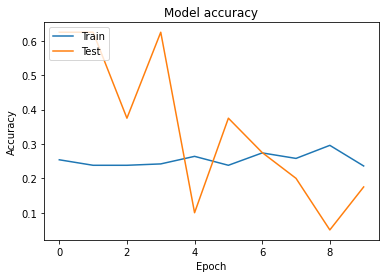

In [15]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()          


2/2 [==============================] - 1s 106ms/step
[0. 0. 1. 0.]
[0.25708607 0.2365662  0.26046333 0.2458843 ]
<class 'numpy.ndarray'>
[[0.75 0.   0.25 0.  ]
 [0.5  0.   0.5  0.  ]
 [0.   0.   1.   0.  ]
 [0.44 0.   0.56 0.  ]]


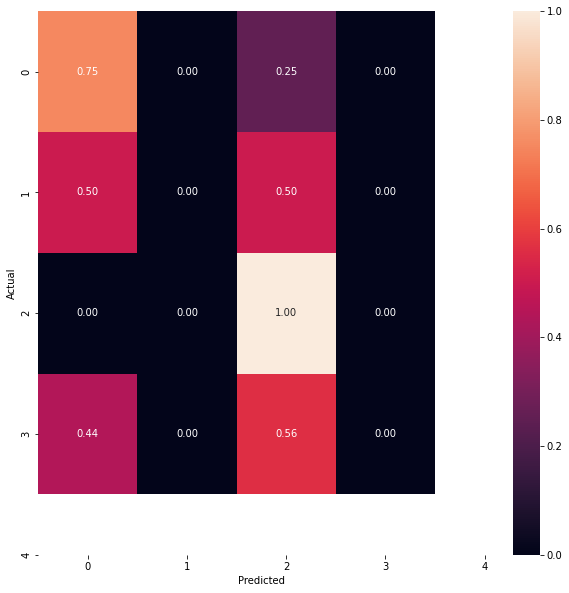

In [16]:
# matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))


predictions=model.predict(x_test)
print(y_test[0])
print(predictions[0])
print(type(predictions[0]))
cf_matrix = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

# sns.heatmap(cf_matrix, annot=True)

cmn = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))

print(cmn)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=True)
